In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import cv2
import json
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
#from transformers import AutoTokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense,Flatten, GlobalAveragePooling2D, Concatenate, Dropout, BatchNormalization, concatenate
from tensorflow.keras.utils import Sequence,to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import time


In [3]:
base_path = "yelp_dataset/"

In [5]:
df_business = pd.read_csv(base_path + 'yelp_business.csv')
df_business.head()

business_id                      name  \
0  Pns2l4eNsfO8kk83dixA6A  Abby Rappoport, LAC, CMQ   
1  mpf3x-BjTdTEA3yCZrAYPw             The UPS Store   
2  tUFrWirKiKi_TAnsVWINQQ                    Target   
3  MTSW4McQd7CbVtyjqoe9mw        St Honore Pastries   
4  mWMc6_wTdE0EUBKIGXDVfA  Perkiomen Valley Brewery   

                           address           city state postal_code  \
0           1616 Chapala St, Ste 2  Santa Barbara    CA       93101   
1  87 Grasso Plaza Shopping Center         Affton    MO       63123   
2             5255 E Broadway Blvd         Tucson    AZ       85711   
3                      935 Race St   Philadelphia    PA       19107   
4                    101 Walnut St     Green Lane    PA       18054   

    latitude   longitude  stars  review_count  is_open  \
0  34.426679 -119.711197    5.0             7        0   
1  38.551126  -90.335695    3.0            15        1   
2  32.223236 -110.880452    3.5            22        0   
3  39.955505  -75.155564    4.0            80        1   
4  40.338183  -75.471659    4.5            13        1   

                                          attributes  \
0                      {'ByAppointmentOnly': 'True'}   
1             {'BusinessAcceptsCreditCards': 'True'}   
2  {'BikeParking': 'True', 'BusinessAcceptsCredit...   
3  {'RestaurantsDelivery': 'False', 'OutdoorSeati...   
4  {'BusinessAcceptsCreditCards': 'True', 'Wheelc...   

                                          categories  \
0  Doctors, Traditional Chinese Medicine, Naturop...   
1  Shipping Centers, Local Services, Notaries, Ma...   
2  Department Stores, Shopping, Fashion, Home & G...   
3  Restaurants, Food, Bubble Tea, Coffee & Tea, B...   
4                          Brewpubs, Breweries, Food   

                                               hours  
0                                                NaN  
1  {'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ...  
2  {'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ...  
3  {'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...  
4  {'Wednesday': '14:0-22:0', 'Thursday': '16:0-2...

In [7]:
photo_path = base_path + r"photos"
photos_df = pd.read_json(base_path + 'photos.json', lines=True)
photos_df.head()

photo_id             business_id  \
0  zsvj7vloL4L5jhYyPIuVwg  Nk-SJhPlDBkAZvfsADtccA   
1  HCUdRJHHm_e0OCTlZetGLg  yVZtL5MmrpiivyCIrVkGgA   
2  vkr8T0scuJmGVvN2HJelEA  _ab50qdWOk0DdB6XOrBitw   
3  pve7D6NUrafHW3EAORubyw  SZU9c8V2GuREDN5KgyHFJw   
4  H52Er-uBg6rNrHcReWTD2w  Gzur0f0XMkrVxIwYJvOt2g   

                                             caption    label  
0  Nice rock artwork everywhere and craploads of ...   inside  
1                                                     outside  
2                                     oyster shooter    drink  
3                                      Shrimp scampi     food  
4                                                        food

In [9]:
photos_df['label' ].unique()

array(['inside', 'outside', 'drink', 'food', 'menu'], dtype=object)

In [11]:
df_business.shape

(150346, 14)

In [13]:
photos_df.shape

(200100, 4)

In [15]:
if 'category' in photos_df.columns:
    label_column = 'category'
elif 'label' in photos_df.columns:
    label_column = 'label'
else:
    raise ValueError("The JSON file does not contain a label column.")

/var/folders/fg/9nf31wlx7_scn2ycc5nqrhv80000gn/T/ipykernel_29692/3666958647.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", len(label_counts))


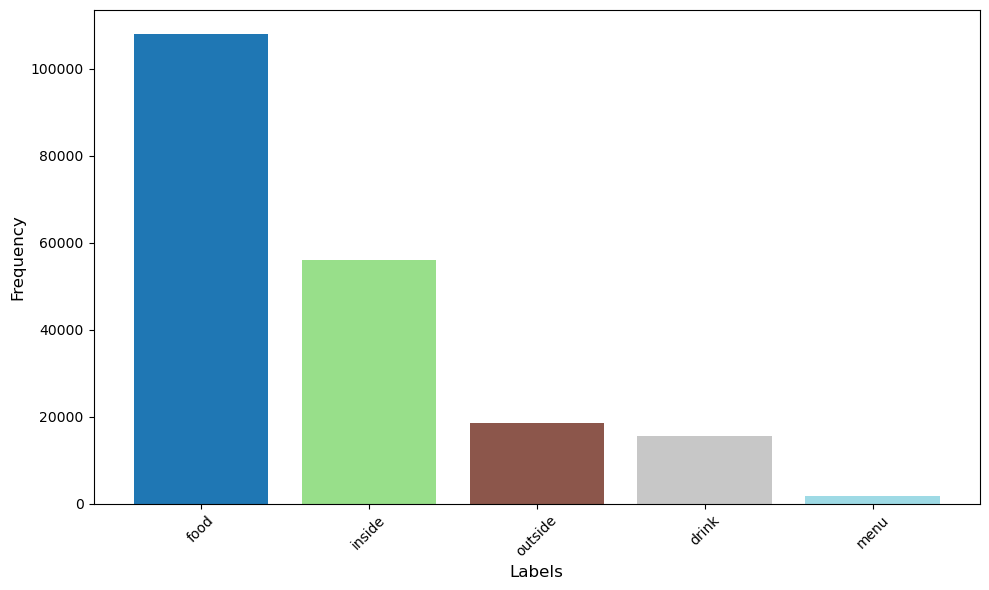

In [17]:
label_counts = photos_df[label_column].value_counts()
colors = plt.cm.get_cmap("tab20", len(label_counts))
color_list = [colors(i) for i in range(len(label_counts))]
plt.figure(figsize=(10, 6))
bars = plt.bar(label_counts.index, label_counts.values, color=color_list)
plt.xlabel("Labels", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
image_dir = photo_path

In [23]:
output_base = base_path + "Processed"

In [25]:
valid_labels = ['inside', 'outside', 'food', 'drink', 'menu']
photos_df = photos_df[photos_df['label'].isin(valid_labels)]

In [27]:
# import os
# import pandas as pd
# import shutil
# from sklearn.model_selection import train_test_split

# #Clear previous data if rerunning
# def clear_directory(path):
#     if os.path.exists(path):
#         shutil.rmtree(path)
#     os.makedirs(path)

# # Clear base train/test directories before starting
# clear_directory(os.path.join(output_base, 'train'))
# clear_directory(os.path.join(output_base, 'test'))

# # Create train/test split per label
# for label in valid_labels:
#     label_df = photos_df[photos_df['label'] == label]
    
#     # Split into train and test
#     train_df, test_df = train_test_split(label_df, test_size=0.2, random_state=42)

#     # Create target directories
#     train_label_dir = os.path.join(output_base, 'train', label)
#     test_label_dir = os.path.join(output_base, 'test', label)
#     os.makedirs(train_label_dir, exist_ok=True)
#     os.makedirs(test_label_dir, exist_ok=True)

#     print(f"🔄 Processing label: {label} ({len(train_df)} train, {len(test_df)} test images)")

#     # Copy train images
#     for photo_id in train_df['photo_id']:
#         src = os.path.join(image_dir, f"{photo_id}.jpg")
#         dst = os.path.join(train_label_dir, f"{photo_id}.jpg")
#         if os.path.exists(src):
#             shutil.copy2(src, dst)
#         else:
#             print(f"⚠️ Missing file: {src}")

#     # Copy test images
#     for photo_id in test_df['photo_id']:
#         src = os.path.join(image_dir, f"{photo_id}.jpg")
#         dst = os.path.join(test_label_dir, f"{photo_id}.jpg")
#         if os.path.exists(src):
#             shutil.copy2(src, dst)
#         else:
#             print(f"⚠️ Missing file: {src}")

# print("✅ All image folders created and populated successfully.")


In [30]:
df = photos_df.merge(df_business[['business_id', 'categories']], on='business_id', how='left')

In [32]:
df.head()

photo_id             business_id  \
0  zsvj7vloL4L5jhYyPIuVwg  Nk-SJhPlDBkAZvfsADtccA   
1  HCUdRJHHm_e0OCTlZetGLg  yVZtL5MmrpiivyCIrVkGgA   
2  vkr8T0scuJmGVvN2HJelEA  _ab50qdWOk0DdB6XOrBitw   
3  pve7D6NUrafHW3EAORubyw  SZU9c8V2GuREDN5KgyHFJw   
4  H52Er-uBg6rNrHcReWTD2w  Gzur0f0XMkrVxIwYJvOt2g   

                                             caption    label  \
0  Nice rock artwork everywhere and craploads of ...   inside   
1                                                     outside   
2                                     oyster shooter    drink   
3                                      Shrimp scampi     food   
4                                                        food   

                                          categories  
0  Restaurants, Pubs, Nightlife, American (Tradit...  
1  Barbeque, Sandwiches, American (Traditional), ...  
2  Live/Raw Food, Seafood, Restaurants, Cajun/Creole  
3  Live/Raw Food, Restaurants, Seafood, Beer Bar,...  
4  Restaurants, Vegan, Food, Ice Cream & Frozen Y...

In [34]:
df['label'].value_counts()

label
food       108152
inside      56031
outside     18569
drink       15670
menu         1678
Name: count, dtype: int64

In [36]:
df.drop(["business_id","caption"],axis=1,inplace=True)

In [38]:
df.head()

photo_id    label  \
0  zsvj7vloL4L5jhYyPIuVwg   inside   
1  HCUdRJHHm_e0OCTlZetGLg  outside   
2  vkr8T0scuJmGVvN2HJelEA    drink   
3  pve7D6NUrafHW3EAORubyw     food   
4  H52Er-uBg6rNrHcReWTD2w     food   

                                          categories  
0  Restaurants, Pubs, Nightlife, American (Tradit...  
1  Barbeque, Sandwiches, American (Traditional), ...  
2  Live/Raw Food, Seafood, Restaurants, Cajun/Creole  
3  Live/Raw Food, Restaurants, Seafood, Beer Bar,...  
4  Restaurants, Vegan, Food, Ice Cream & Frozen Y...

In [40]:
Processed_Files_Path = base_path +  "processed"
Photos_path = photo_path
TRAIN_DIR = os.path.join(Processed_Files_Path, "train")
TEST_DIR = os.path.join(Processed_Files_Path, "test")
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [42]:
df = df.dropna(subset=['label', 'photo_id'])

In [44]:
df["image_path"] = df["photo_id"].apply(lambda x: os.path.join(Photos_path, f"{x}.jpg"))

In [46]:
label_encoder = LabelEncoder()
df["label_encoded"] = label_encoder.fit_transform(df["label"])

In [48]:
print("Label to index mapping:")
for idx, label in enumerate(label_encoder.classes_):
    print(f"{label} => {idx}")

Label to index mapping:
drink => 0
food => 1
inside => 2
menu => 3
outside => 4


In [50]:
tokenizer = Tokenizer(num_words=500)
tokenizer.fit_on_texts(df["categories"].fillna(""))

In [52]:
metadata_seq = tokenizer.texts_to_matrix(df["categories"].fillna(""), mode='binary')
metadata_dim = metadata_seq.shape[1]

In [53]:
metadata_seq

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [54]:
df.head()

photo_id    label  \
0  zsvj7vloL4L5jhYyPIuVwg   inside   
1  HCUdRJHHm_e0OCTlZetGLg  outside   
2  vkr8T0scuJmGVvN2HJelEA    drink   
3  pve7D6NUrafHW3EAORubyw     food   
4  H52Er-uBg6rNrHcReWTD2w     food   

                                          categories  \
0  Restaurants, Pubs, Nightlife, American (Tradit...   
1  Barbeque, Sandwiches, American (Traditional), ...   
2  Live/Raw Food, Seafood, Restaurants, Cajun/Creole   
3  Live/Raw Food, Restaurants, Seafood, Beer Bar,...   
4  Restaurants, Vegan, Food, Ice Cream & Frozen Y...   

                                       image_path  label_encoded  
0  yelp_dataset/photos/zsvj7vloL4L5jhYyPIuVwg.jpg              2  
1  yelp_dataset/photos/HCUdRJHHm_e0OCTlZetGLg.jpg              4  
2  yelp_dataset/photos/vkr8T0scuJmGVvN2HJelEA.jpg              0  
3  yelp_dataset/photos/pve7D6NUrafHW3EAORubyw.jpg              1  
4  yelp_dataset/photos/H52Er-uBg6rNrHcReWTD2w.jpg              1

In [59]:
def read_image(path):
    image = cv2.imread(path)
    if image is None:
        # Return black image if not found
        return np.zeros((224, 224, 3), dtype=np.uint8)
    return image

def resize_image(image, target_size=(224, 224)):
    return cv2.resize(image, target_size)

def apply_gaussian_blur(image, kernel_size=(3, 3)):
    return cv2.GaussianBlur(image, kernel_size, 0)

def histogram_equalization(image):
    yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    yuv[:, :, 0] = cv2.equalizeHist(yuv[:, :, 0])
    return cv2.cvtColor(yuv, cv2.COLOR_YUV2BGR)

def apply_threshold_mask(image, threshold=100):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
    result = image.copy()
    result[mask == 0] = 0
    return result

def normalize_image(image):
    return image.astype(np.float32) / 255.0

# Full preprocessing combining the steps
def preprocess_image(path, target_size=(224, 224)):
    image = read_image(path)
    image = resize_image(image, target_size)
    image = apply_gaussian_blur(image)
    image = histogram_equalization(image)
    image = apply_threshold_mask(image)
    image = normalize_image(image)
    return image


In [61]:
class AugmentedImageMetadataGenerator(Sequence):
    def __init__(self, image_paths, metadata, labels, batch_size=32, target_size=(224, 224), augment=True):
        self.image_paths = image_paths
        self.metadata = metadata
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.augment = augment

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_paths = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_meta = self.metadata[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        images = [self.load_and_augment_image(p) for p in batch_paths]
        return (np.array(images), np.array(batch_meta)), np.array(batch_labels)

    def load_and_augment_image(self, path):
        image = preprocess_image(path, self.target_size)

        if self.augment:
            if np.random.rand() < 0.5:
                image = np.fliplr(image)
            if np.random.rand() < 0.5:
                angle = np.random.uniform(-15, 15)
                M = cv2.getRotationMatrix2D((self.target_size[0]//2, self.target_size[1]//2), angle, 1)
                image = cv2.warpAffine(image, M, self.target_size)

        return image

In [63]:
X_img = df["image_path"].values
X_meta = metadata_seq
y = df["label_encoded"].values

In [65]:
from sklearn.utils import resample

def undersample_data(image_paths, metadata, labels):
    # Ensure metadata is a list of 1D structures (like tuples or flat lists)
    flat_meta = [m.tolist() if isinstance(m, np.ndarray) else m for m in metadata]

    df = pd.DataFrame({
        'path': image_paths,
        'meta': flat_meta,
        'label': labels
    })

    min_class_count = df['label'].value_counts().min()

    balanced_df = pd.concat([
        resample(group, replace=False, n_samples=min_class_count, random_state=42)
        for label, group in df.groupby('label')
    ])

    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
    return balanced_df['path'].tolist(), list(balanced_df['meta']), balanced_df['label'].tolist()

In [67]:
# X_img_bal, X_meta_bal, y_bal = undersample_data(X_img, X_meta, y)

In [69]:
# X_img_train, X_img_val, X_meta_train, X_meta_val, y_train, y_val = train_test_split(
#     X_img_bal, X_meta_bal, y_bal, test_size=0.2, stratify=y_bal, random_state=42
# )


In [71]:
values, counts = np.unique(y, return_counts=True)
for val, count in zip(values, counts):
    print(f"Label {val}: {count} samples")

Label 0: 15670 samples
Label 1: 108152 samples
Label 2: 56031 samples
Label 3: 1678 samples
Label 4: 18569 samples


In [73]:
X_img_bal, X_meta_bal, y_bal = undersample_data(X_img, X_meta, y)

In [74]:
X_img_train, X_img_val, X_meta_train, X_meta_val, y_train, y_val = train_test_split(
    X_img_bal, X_meta_bal, y_bal, test_size=0.2, stratify=y_bal, random_state=42)

In [75]:
values, counts = np.unique(y_train, return_counts=True)
for val, count in zip(values, counts):
    print(f"Label {val}: {count} samples")

Label 0: 1342 samples
Label 1: 1343 samples
Label 2: 1342 samples
Label 3: 1342 samples
Label 4: 1343 samples


In [79]:
train_gen = AugmentedImageMetadataGenerator(X_img_train, X_meta_train, y_train, augment=True)
val_gen = AugmentedImageMetadataGenerator(X_img_val, X_meta_val, y_val, augment=False)

In [81]:
print(f"Metadata feature size: {metadata_dim}")
print(f"Train batches: {len(train_gen)}, Validation batches: {len(val_gen)}")

Metadata feature size: 500
Train batches: 210, Validation batches: 53


In [83]:
df.head()

photo_id    label  \
0  zsvj7vloL4L5jhYyPIuVwg   inside   
1  HCUdRJHHm_e0OCTlZetGLg  outside   
2  vkr8T0scuJmGVvN2HJelEA    drink   
3  pve7D6NUrafHW3EAORubyw     food   
4  H52Er-uBg6rNrHcReWTD2w     food   

                                          categories  \
0  Restaurants, Pubs, Nightlife, American (Tradit...   
1  Barbeque, Sandwiches, American (Traditional), ...   
2  Live/Raw Food, Seafood, Restaurants, Cajun/Creole   
3  Live/Raw Food, Restaurants, Seafood, Beer Bar,...   
4  Restaurants, Vegan, Food, Ice Cream & Frozen Y...   

                                       image_path  label_encoded  
0  yelp_dataset/photos/zsvj7vloL4L5jhYyPIuVwg.jpg              2  
1  yelp_dataset/photos/HCUdRJHHm_e0OCTlZetGLg.jpg              4  
2  yelp_dataset/photos/vkr8T0scuJmGVvN2HJelEA.jpg              0  
3  yelp_dataset/photos/pve7D6NUrafHW3EAORubyw.jpg              1  
4  yelp_dataset/photos/H52Er-uBg6rNrHcReWTD2w.jpg              1

In [85]:
df.shape

(200100, 5)

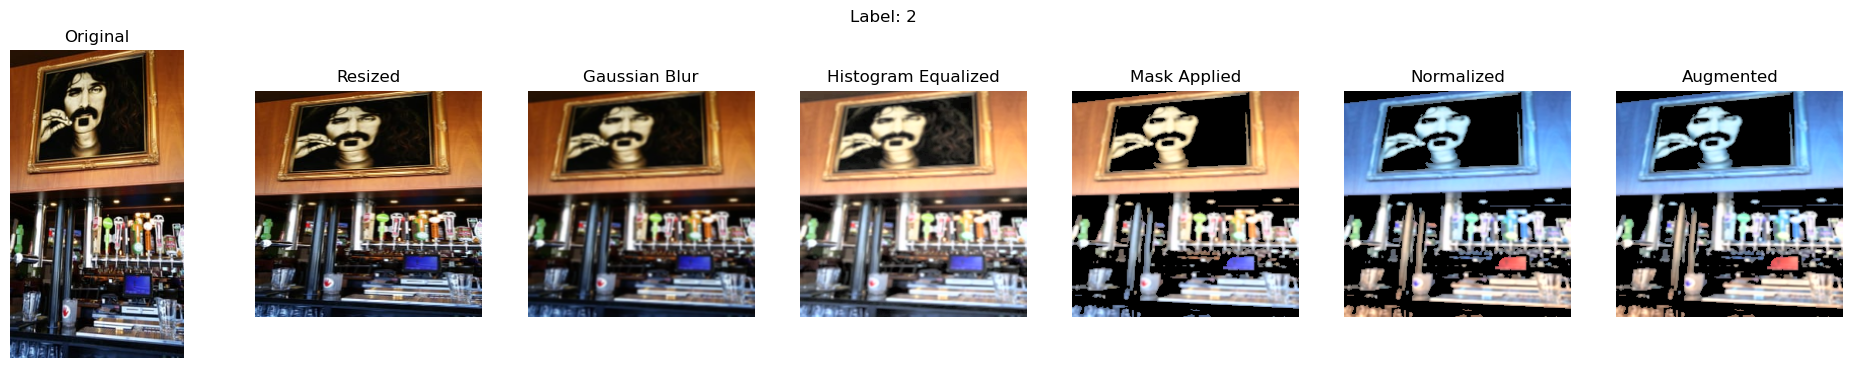

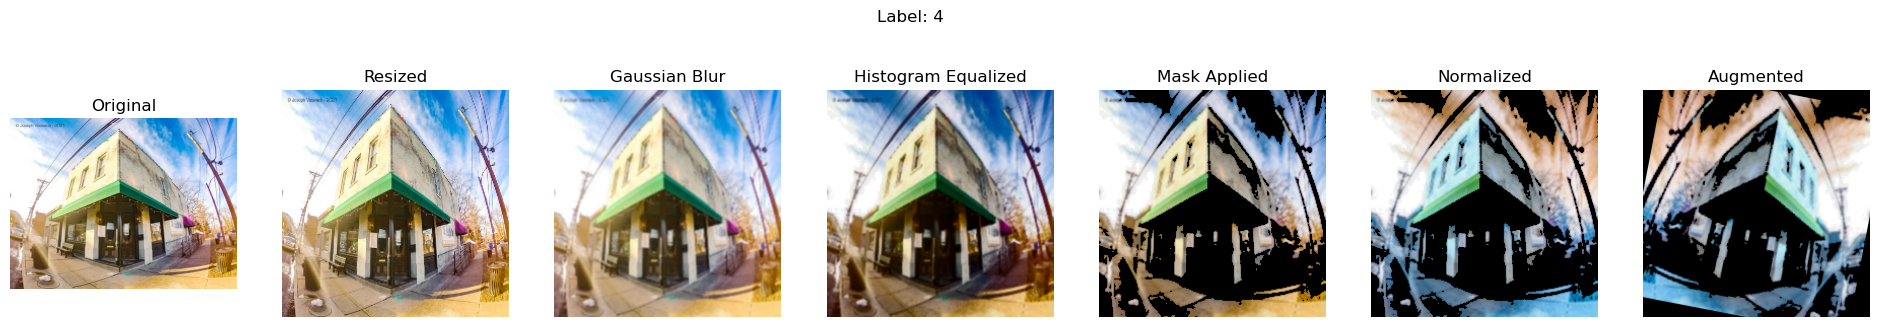

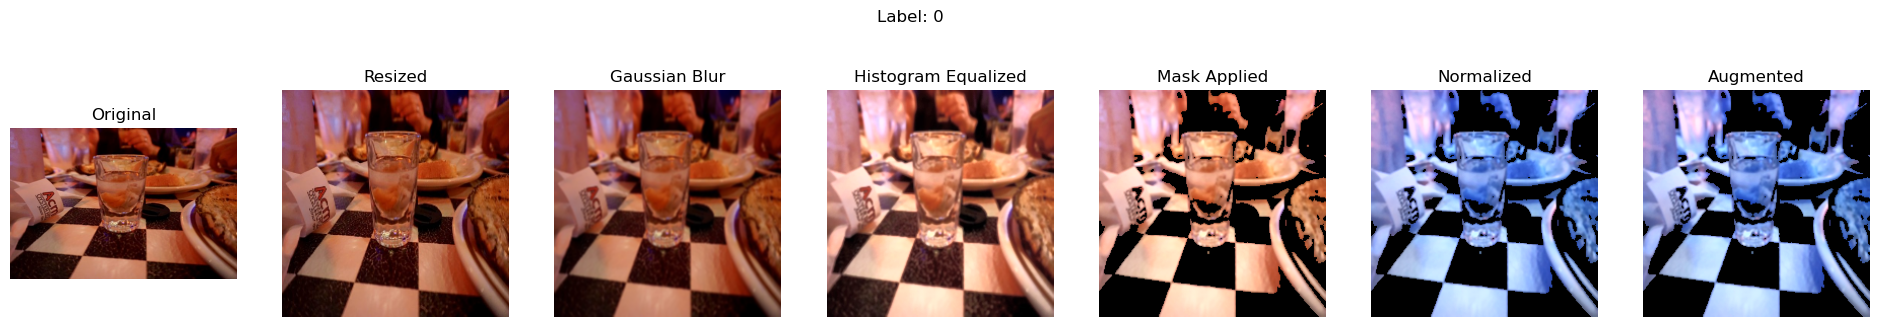

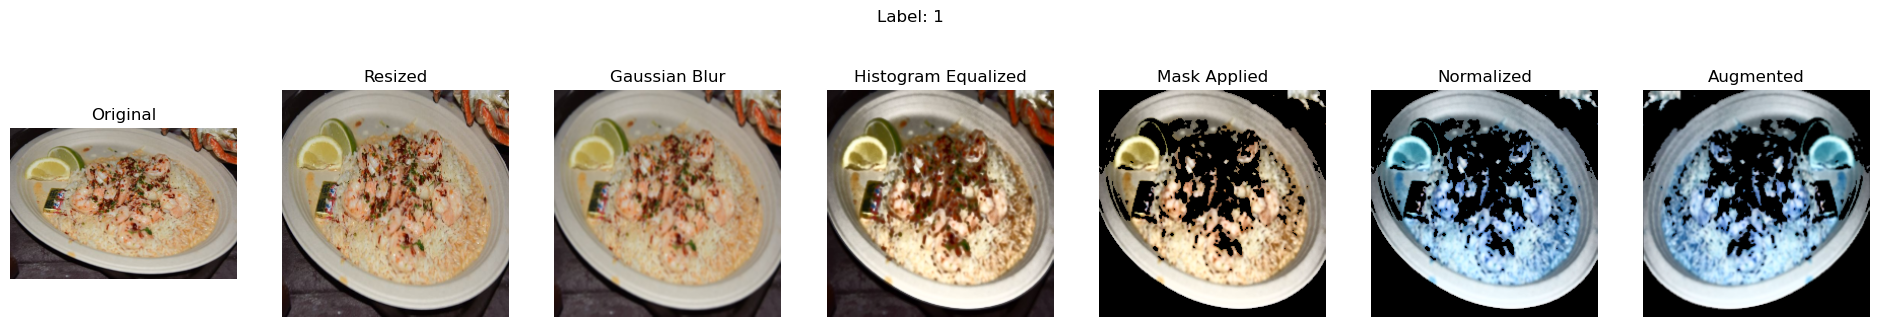

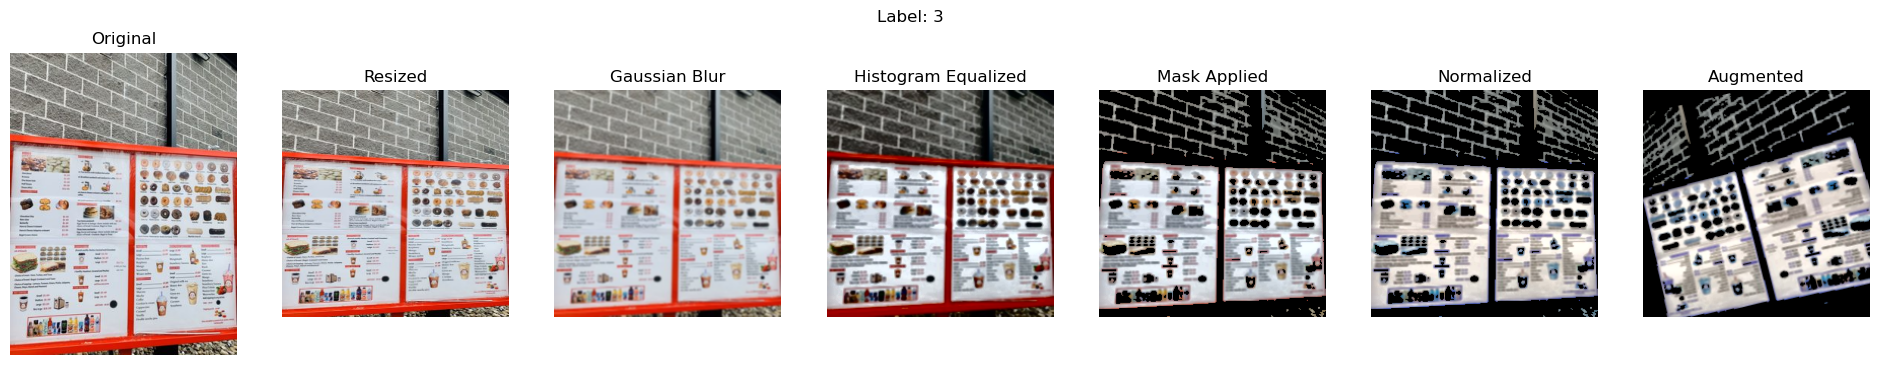

In [87]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Assume these functions are already defined as per your last request:
# read_image, resize_image, apply_gaussian_blur, histogram_equalization,
# apply_threshold_mask, normalize_image

def visualize_preprocessing_and_augmentation(df, label_column, augment=True, target_size=(224, 224)):
    unique_labels = df[label_column].unique()
    
    for label in unique_labels:
        # Get one image path for this label
        img_path = df[df[label_column] == label]['image_path'].iloc[0]
        
        original = read_image(img_path)
        original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
        
        resized = resize_image(original, target_size)
        resized_rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
        
        blurred = apply_gaussian_blur(resized)
        blurred_rgb = cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB)
        
        equalized = histogram_equalization(blurred)
        equalized_rgb = cv2.cvtColor(equalized, cv2.COLOR_BGR2RGB)
        
        masked = apply_threshold_mask(equalized)
        masked_rgb = cv2.cvtColor(masked, cv2.COLOR_BGR2RGB)
        
        normalized = normalize_image(masked)
        
        augmented = normalized.copy()
        if augment:
            if np.random.rand() < 0.5:
                augmented = np.fliplr(augmented)
            if np.random.rand() < 0.5:
                angle = np.random.uniform(-15, 15)
                M = cv2.getRotationMatrix2D((target_size[0]//2, target_size[1]//2), angle, 1)
                augmented = cv2.warpAffine(augmented, M, target_size)
        
        # Plotting all steps
        fig, axes = plt.subplots(1, 7, figsize=(24, 4))
        axes[0].imshow(original_rgb)
        axes[0].set_title('Original')
        axes[1].imshow(resized_rgb)
        axes[1].set_title('Resized')
        axes[2].imshow(blurred_rgb)
        axes[2].set_title('Gaussian Blur')
        axes[3].imshow(equalized_rgb)
        axes[3].set_title('Histogram Equalized')
        axes[4].imshow(masked_rgb)
        axes[4].set_title('Mask Applied')
        axes[5].imshow(normalized)
        axes[5].set_title('Normalized')
        axes[6].imshow(augmented)
        axes[6].set_title('Augmented')

        for ax in axes:
            ax.axis('off')

        plt.suptitle(f'Label: {label}')
        plt.show()

# Then call the function with your dataframe and label column name:
visualize_preprocessing_and_augmentation(df, 'label_encoded', augment=True)


In [89]:
# Image input shape
img_input_shape = (224, 224, 3)

# Metadata input shape (adjust according to your metadata feature size)
meta_input_shape = (metadata_dim,)  # e.g., (10,)

num_classes = len(np.unique(y_train))  # Or set manually

# 1. Load pretrained VGG16 without top classifier layers
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=img_input_shape)

# Freezing VGG layers at first to train only top layers initially
for layer in vgg_base.layers:
    layer.trainable = False

# 2. Flatten output of VGG base
vgg_features = Flatten()(vgg_base.output)

# 3. Metadata input
meta_input = Input(shape=meta_input_shape, name='metadata_input')

# 4. Dense layers for metadata
meta_dense = Dense(64, activation='relu')(meta_input)
meta_dense = Dropout(0.3)(meta_dense)

# 5. Concatenate image and metadata features
concat = Concatenate()([vgg_features, meta_dense])

# 6. Add custom top layers for classification/regression
x = Dense(256, activation='relu')(concat)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)  # For classification

# 7. Define the complete model
model = Model(inputs=[vgg_base.input, meta_input], outputs=output)

# 8. Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 14, 14,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 14, 14,    │  2,359,808 │ block5_conv1[0][

 Total params: 21,187,205 (80.82 MB)

 Trainable params: 6,472,517 (24.69 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [44]:
early_stop = EarlyStopping(
    monitor='val_loss',      # Metric to watch
    patience=3,              # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore model weights from the epoch with best val_loss
)


In [45]:
start_time = time.time()

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stop]
)

end_time = time.time()
training_time = end_time - start_time

print(f"Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes).")


Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


159/210 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.5837 - loss: 1.0382

libpng warning: iCCP: known incorrect sRGB profile


200/210 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6072 - loss: 0.9860

libpng warning: iCCP: known incorrect sRGB profile


210/210 ━━━━━━━━━━━━━━━━━━━━ 301s 1s/step - accuracy: 0.6124 - loss: 0.9743 - val_accuracy: 0.8272 - val_loss: 0.4849
Epoch 2/10
 32/210 ━━━━━━━━━━━━━━━━━━━━ 3:26 1s/step - accuracy: 0.8187 - loss: 0.4903

libpng warning: iCCP: known incorrect sRGB profile


 71/210 ━━━━━━━━━━━━━━━━━━━━ 2:43 1s/step - accuracy: 0.8124 - loss: 0.4983

libpng warning: iCCP: known incorrect sRGB profile


210/210 ━━━━━━━━━━━━━━━━━━━━ 311s 1s/step - accuracy: 0.8086 - loss: 0.5101 - val_accuracy: 0.8331 - val_loss: 0.4533
Epoch 3/10
  9/210 ━━━━━━━━━━━━━━━━━━━━ 3:50 1s/step - accuracy: 0.8188 - loss: 0.4162

libpng warning: iCCP: known incorrect sRGB profile


 22/210 ━━━━━━━━━━━━━━━━━━━━ 3:38 1s/step - accuracy: 0.8354 - loss: 0.4341

libpng warning: iCCP: known incorrect sRGB profile


210/210 ━━━━━━━━━━━━━━━━━━━━ 309s 1s/step - accuracy: 0.8413 - loss: 0.4496 - val_accuracy: 0.8200 - val_loss: 0.4530
Epoch 4/10
 87/210 ━━━━━━━━━━━━━━━━━━━━ 2:26 1s/step - accuracy: 0.8414 - loss: 0.4174

libpng warning: iCCP: known incorrect sRGB profile


139/210 ━━━━━━━━━━━━━━━━━━━━ 1:23 1s/step - accuracy: 0.8462 - loss: 0.4091

libpng warning: iCCP: known incorrect sRGB profile


210/210 ━━━━━━━━━━━━━━━━━━━━ 305s 1s/step - accuracy: 0.8497 - loss: 0.4029 - val_accuracy: 0.8594 - val_loss: 0.3861
Epoch 5/10
 92/210 ━━━━━━━━━━━━━━━━━━━━ 2:23 1s/step - accuracy: 0.8748 - loss: 0.3526

libpng warning: iCCP: known incorrect sRGB profile


131/210 ━━━━━━━━━━━━━━━━━━━━ 1:35 1s/step - accuracy: 0.8738 - loss: 0.3551

libpng warning: iCCP: known incorrect sRGB profile


210/210 ━━━━━━━━━━━━━━━━━━━━ 311s 1s/step - accuracy: 0.8723 - loss: 0.3577 - val_accuracy: 0.8546 - val_loss: 0.3899
Epoch 6/10
 83/210 ━━━━━━━━━━━━━━━━━━━━ 2:32 1s/step - accuracy: 0.8894 - loss: 0.3101

libpng warning: iCCP: known incorrect sRGB profile


108/210 ━━━━━━━━━━━━━━━━━━━━ 2:02 1s/step - accuracy: 0.8888 - loss: 0.3104

libpng warning: iCCP: known incorrect sRGB profile


210/210 ━━━━━━━━━━━━━━━━━━━━ 311s 1s/step - accuracy: 0.8866 - loss: 0.3146 - val_accuracy: 0.8635 - val_loss: 0.3823
Epoch 7/10
 93/210 ━━━━━━━━━━━━━━━━━━━━ 2:18 1s/step - accuracy: 0.8943 - loss: 0.3023

libpng warning: iCCP: known incorrect sRGB profile


143/210 ━━━━━━━━━━━━━━━━━━━━ 1:18 1s/step - accuracy: 0.8949 - loss: 0.2982

libpng warning: iCCP: known incorrect sRGB profile


210/210 ━━━━━━━━━━━━━━━━━━━━ 305s 1s/step - accuracy: 0.8940 - loss: 0.2977 - val_accuracy: 0.8546 - val_loss: 0.3833
Epoch 8/10
 69/210 ━━━━━━━━━━━━━━━━━━━━ 2:47 1s/step - accuracy: 0.9059 - loss: 0.2420

libpng warning: iCCP: known incorrect sRGB profile


 76/210 ━━━━━━━━━━━━━━━━━━━━ 2:39 1s/step - accuracy: 0.9054 - loss: 0.2435

libpng warning: iCCP: known incorrect sRGB profile


210/210 ━━━━━━━━━━━━━━━━━━━━ 307s 1s/step - accuracy: 0.9026 - loss: 0.2559 - val_accuracy: 0.8445 - val_loss: 0.4104
Epoch 9/10
 22/210 ━━━━━━━━━━━━━━━━━━━━ 3:42 1s/step - accuracy: 0.9208 - loss: 0.2254

libpng warning: iCCP: known incorrect sRGB profile


106/210 ━━━━━━━━━━━━━━━━━━━━ 2:05 1s/step - accuracy: 0.9190 - loss: 0.2271

libpng warning: iCCP: known incorrect sRGB profile


210/210 ━━━━━━━━━━━━━━━━━━━━ 511s 2s/step - accuracy: 0.9156 - loss: 0.2313 - val_accuracy: 0.8534 - val_loss: 0.3964
Training completed in 2972.25 seconds (49.54 minutes).


In [46]:
val_loss, val_accuracy = model.evaluate(val_gen)
print(f"Test Accuracy: {val_accuracy:.4f}, Test Loss: {val_loss:.4f}")

53/53 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.8597 - loss: 0.3734
Test Accuracy: 0.8635, Test Loss: 0.3823


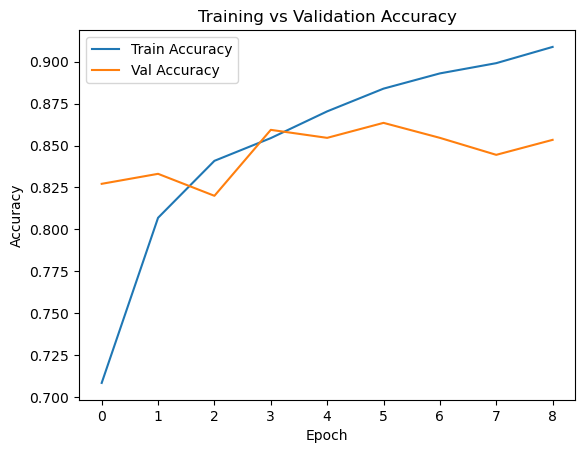

In [47]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()


In [48]:
# pred_probs = model.predict((np.array([img]), np.array([meta])))
# pred_label = label_encoder.inverse_transform([np.argmax(pred_probs)])
# print("Predicted Label:", pred_label[0])


In [49]:
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

# Predict on the full validation set
y_pred_probs = model.predict(val_gen, verbose=1)
y_true = val_gen.labels  



53/53 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step


In [50]:
auc_score = roc_auc_score(y_true, y_pred_probs, multi_class='ovr')
print(f"AUC Score: {auc_score:.4f}")

AUC Score: 0.9799


In [51]:
y_pred_classes = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", cm)

#Classification report
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))


Confusion Matrix:
 [[293  18  18   1   6]
 [ 14 306  10   1   4]
 [ 17  15 252   4  48]
 [  2   5  13 300  16]
 [  1   4  30   2 298]]
              precision    recall  f1-score   support

       drink       0.90      0.87      0.88       336
        food       0.88      0.91      0.90       335
      inside       0.78      0.75      0.76       336
        menu       0.97      0.89      0.93       336
     outside       0.80      0.89      0.84       335

    accuracy                           0.86      1678
   macro avg       0.87      0.86      0.86      1678
weighted avg       0.87      0.86      0.86      1678



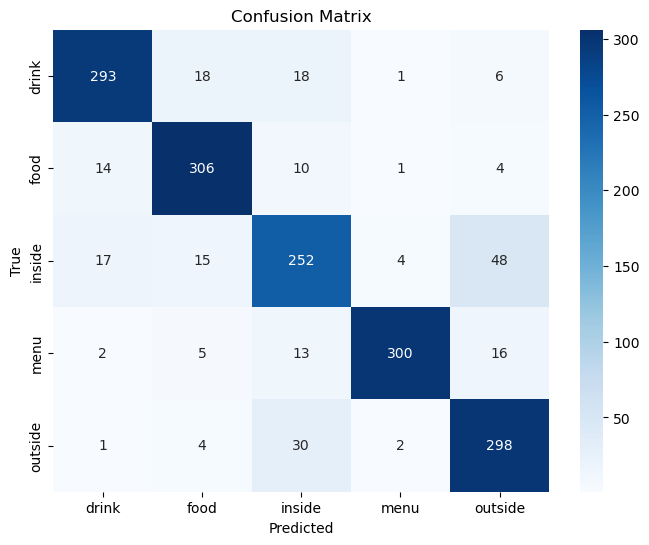

In [52]:
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

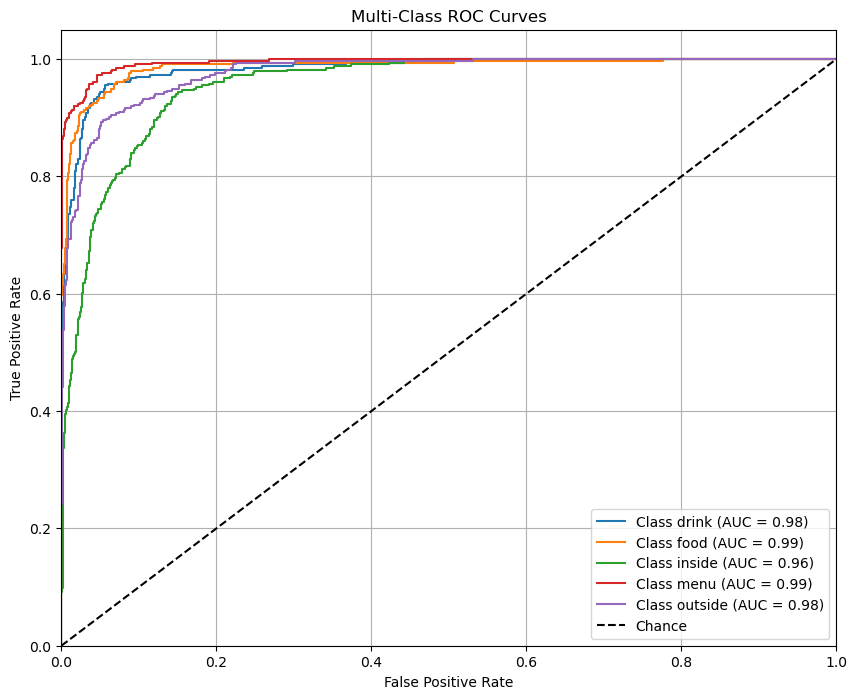

In [53]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


# 1. Binarize the true labels
n_classes = len(label_encoder.classes_)
y_true_bin = label_binarize(y_true, classes=range(n_classes))

# 2. Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 3. Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


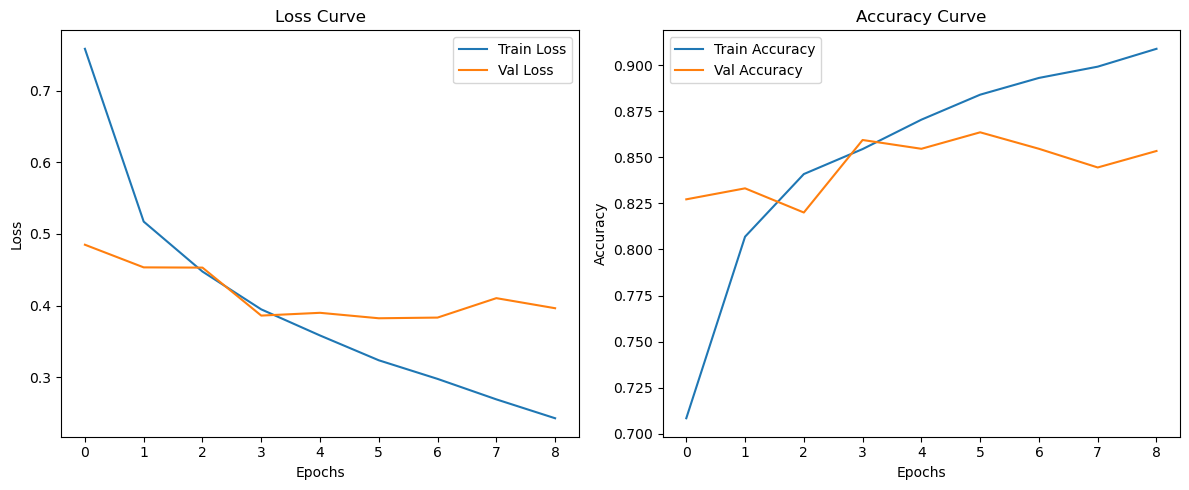

In [54]:
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()


In [91]:
import pickle
from tensorflow.keras.models import load_model

dump_base_path = "dumps/"

# # --- Saving ---

# # Save Keras model (architecture + weights + optimizer)
# model.save(dump_base_path + 'vgg_transfer_learning_model_1.h5')

# # Save Label Encoder
# with open(dump_base_path + 'label_encoder.pkl', 'wb') as f:
#     pickle.dump(label_encoder, f)

# # Save metadata
# with open(dump_base_path + 'metadata_seq.pkl', 'wb') as f:
#     pickle.dump(metadata_seq, f)


# # Save tokenizer
# with open(dump_base_path + 'tokenizer.pkl', 'wb') as f:
#     pickle.dump(tokenizer, f)

# # save training history
# with open(dump_base_path + 'training_history.pkl', 'wb') as f:
#     pickle.dump(history, f)


# --- Loading later ---

# Load model
model = load_model(dump_base_path +'vgg_transfer_learning_model_1.h5')

# Load Label Encoder
with open(dump_base_path + 'label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

# Load metadata scaler
with open(dump_base_path + 'metadata_seq.pkl', 'rb') as f:
    metadata_seq = pickle.load(f)

# Load metadata scaler
with open(dump_base_path + 'tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Load training history (optional)
with open(dump_base_path + 'training_history.pkl', 'rb') as f:
    history = pickle.load(f)


# Fine Tuning:

In [57]:
for layer in vgg_base.layers:
    if layer.name in ['block5_conv1', 'block5_conv2', 'block5_conv3']:
        layer.trainable = True
    else:
        layer.trainable = False

#Printing which layers are now trainable
for layer in model.layers:
    print(f"{layer.name}: {'Trainable' if layer.trainable else 'Frozen'}")

# Recompile with a lower learning rate to avoid large weight updates
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


input_layer: Trainable
block1_conv1: Frozen
block1_conv2: Frozen
block1_pool: Frozen
block2_conv1: Frozen
block2_conv2: Frozen
block2_pool: Frozen
block3_conv1: Frozen
block3_conv2: Frozen
block3_conv3: Frozen
block3_pool: Frozen
block4_conv1: Frozen
block4_conv2: Frozen
block4_conv3: Frozen
block4_pool: Frozen
block5_conv1: Frozen
block5_conv2: Frozen
block5_conv3: Frozen
metadata_input: Trainable
block5_pool: Frozen
dense: Trainable
flatten: Trainable
dropout: Trainable
concatenate: Trainable
dense_1: Trainable
dropout_1: Trainable
dense_2: Trainable


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 14, 14,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 14, 14,    │  2,359,808 │ block5_conv1[0][

 Total params: 21,187,205 (80.82 MB)

 Trainable params: 6,472,517 (24.69 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [58]:
# Retrain the model (now with partial fine-tuning)
fine_tune_history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stop]
)


Epoch 1/10
112/210 ━━━━━━━━━━━━━━━━━━━━ 2:07 1s/step - accuracy: 0.9227 - loss: 0.2238

libpng warning: iCCP: known incorrect sRGB profile


136/210 ━━━━━━━━━━━━━━━━━━━━ 1:34 1s/step - accuracy: 0.9231 - loss: 0.2223

libpng warning: iCCP: known incorrect sRGB profile


210/210 ━━━━━━━━━━━━━━━━━━━━ 339s 2s/step - accuracy: 0.9232 - loss: 0.2189 - val_accuracy: 0.8707 - val_loss: 0.3699
Epoch 2/10
156/210 ━━━━━━━━━━━━━━━━━━━━ 1:07 1s/step - accuracy: 0.9263 - loss: 0.2088

libpng warning: iCCP: known incorrect sRGB profile


201/210 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9268 - loss: 0.2073

libpng warning: iCCP: known incorrect sRGB profile


210/210 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - accuracy: 0.9270 - loss: 0.2070 - val_accuracy: 0.8701 - val_loss: 0.3697
Epoch 3/10
 10/210 ━━━━━━━━━━━━━━━━━━━━ 3:56 1s/step - accuracy: 0.9394 - loss: 0.1935

libpng warning: iCCP: known incorrect sRGB profile


 43/210 ━━━━━━━━━━━━━━━━━━━━ 3:20 1s/step - accuracy: 0.9228 - loss: 0.2102

libpng warning: iCCP: known incorrect sRGB profile


210/210 ━━━━━━━━━━━━━━━━━━━━ 313s 1s/step - accuracy: 0.9297 - loss: 0.1986 - val_accuracy: 0.8683 - val_loss: 0.3713
Epoch 4/10
 47/210 ━━━━━━━━━━━━━━━━━━━━ 3:18 1s/step - accuracy: 0.9270 - loss: 0.2009

libpng warning: iCCP: known incorrect sRGB profile


204/210 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9315 - loss: 0.1972

libpng warning: iCCP: known incorrect sRGB profile


210/210 ━━━━━━━━━━━━━━━━━━━━ 317s 2s/step - accuracy: 0.9316 - loss: 0.1971 - val_accuracy: 0.8707 - val_loss: 0.3692
Epoch 5/10
 17/210 ━━━━━━━━━━━━━━━━━━━━ 3:49 1s/step - accuracy: 0.9384 - loss: 0.1748

libpng warning: iCCP: known incorrect sRGB profile


 79/210 ━━━━━━━━━━━━━━━━━━━━ 2:38 1s/step - accuracy: 0.9442 - loss: 0.1674

libpng warning: iCCP: known incorrect sRGB profile


210/210 ━━━━━━━━━━━━━━━━━━━━ 311s 1s/step - accuracy: 0.9388 - loss: 0.1786 - val_accuracy: 0.8713 - val_loss: 0.3642
Epoch 6/10
122/210 ━━━━━━━━━━━━━━━━━━━━ 1:47 1s/step - accuracy: 0.9387 - loss: 0.1852

libpng warning: iCCP: known incorrect sRGB profile


152/210 ━━━━━━━━━━━━━━━━━━━━ 1:10 1s/step - accuracy: 0.9389 - loss: 0.1842

libpng warning: iCCP: known incorrect sRGB profile


210/210 ━━━━━━━━━━━━━━━━━━━━ 313s 1s/step - accuracy: 0.9387 - loss: 0.1839 - val_accuracy: 0.8701 - val_loss: 0.3679
Epoch 7/10
 43/210 ━━━━━━━━━━━━━━━━━━━━ 3:16 1s/step - accuracy: 0.9301 - loss: 0.2047

libpng warning: iCCP: known incorrect sRGB profile


 67/210 ━━━━━━━━━━━━━━━━━━━━ 2:49 1s/step - accuracy: 0.9301 - loss: 0.2038

libpng warning: iCCP: known incorrect sRGB profile


210/210 ━━━━━━━━━━━━━━━━━━━━ 311s 1s/step - accuracy: 0.9340 - loss: 0.1951 - val_accuracy: 0.8713 - val_loss: 0.3693
Epoch 8/10
 44/210 ━━━━━━━━━━━━━━━━━━━━ 3:20 1s/step - accuracy: 0.9365 - loss: 0.1806

libpng warning: iCCP: known incorrect sRGB profile


146/210 ━━━━━━━━━━━━━━━━━━━━ 1:18 1s/step - accuracy: 0.9406 - loss: 0.1778

libpng warning: iCCP: known incorrect sRGB profile


210/210 ━━━━━━━━━━━━━━━━━━━━ 319s 2s/step - accuracy: 0.9412 - loss: 0.1777 - val_accuracy: 0.8731 - val_loss: 0.3700


In [121]:
val_loss, val_accuracy = model.evaluate(val_gen)
print(f"Test Accuracy: {val_accuracy:.4f}, Test Loss: {val_loss:.4f}")

53/53 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.8747 - loss: 0.3611
Test Accuracy: 0.8713, Test Loss: 0.3642


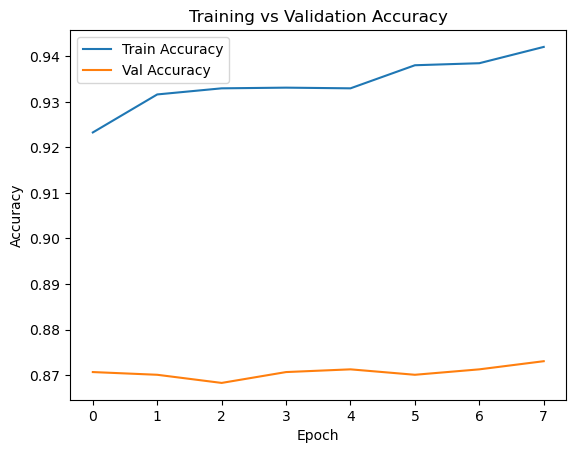

In [122]:
import matplotlib.pyplot as plt

plt.plot(fine_tune_history.history['accuracy'], label='Train Accuracy')
plt.plot(fine_tune_history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()


In [123]:
# pred_probs = model.predict((np.array([img]), np.array([meta])))
# pred_label = label_encoder.inverse_transform([np.argmax(pred_probs)])
# print("Predicted Label:", pred_label[0])


In [124]:
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

# Predict on the full validation set
y_pred_probs = model.predict(val_gen, verbose=1)
y_true = val_gen.labels  



53/53 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step


In [125]:
auc_score = roc_auc_score(y_true, y_pred_probs, multi_class='ovr')
print(f"AUC Score: {auc_score:.4f}")

AUC Score: 0.9816


In [126]:
y_pred_classes = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", cm)

#Classification report
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))


Confusion Matrix:
 [[303  13  16   0   4]
 [ 19 301  12   1   2]
 [ 17  11 268   9  31]
 [  2   3  11 310  10]
 [  2   3  42   8 280]]
              precision    recall  f1-score   support

       drink       0.88      0.90      0.89       336
        food       0.91      0.90      0.90       335
      inside       0.77      0.80      0.78       336
        menu       0.95      0.92      0.93       336
     outside       0.86      0.84      0.85       335

    accuracy                           0.87      1678
   macro avg       0.87      0.87      0.87      1678
weighted avg       0.87      0.87      0.87      1678



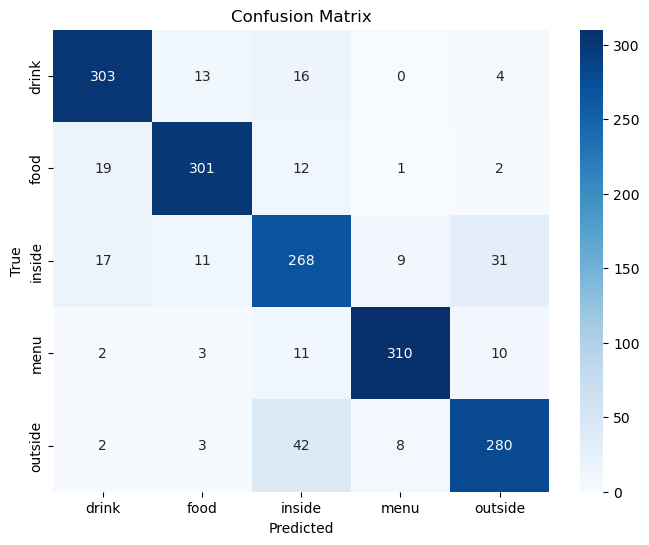

In [127]:
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

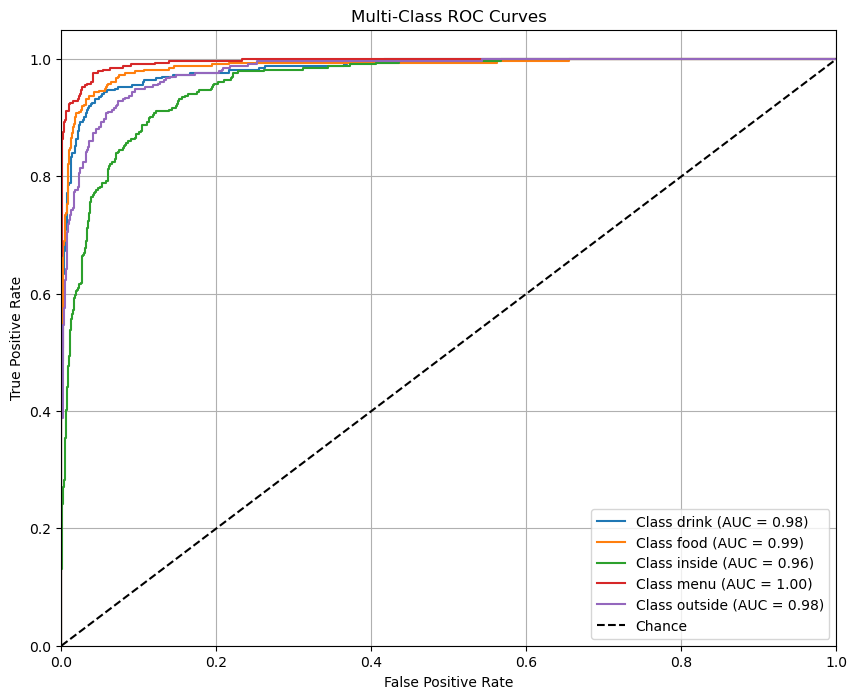

In [128]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


# 1. Binarize the true labels
n_classes = len(label_encoder.classes_)
y_true_bin = label_binarize(y_true, classes=range(n_classes))

# 2. Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 3. Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


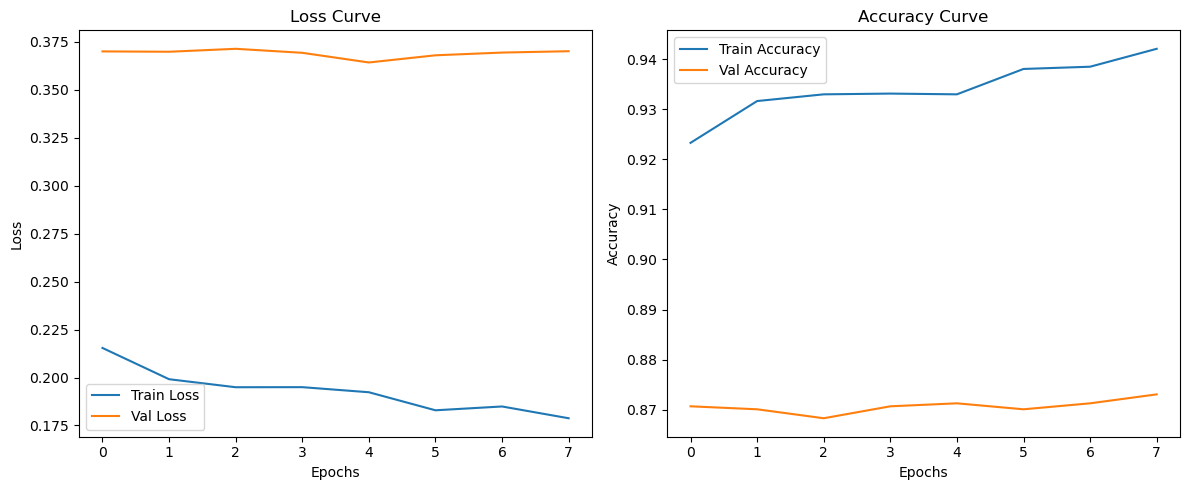

In [129]:
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fine_tune_history.history['loss'], label='Train Loss')
plt.plot(fine_tune_history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(fine_tune_history.history['accuracy'], label='Train Accuracy')
plt.plot(fine_tune_history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()


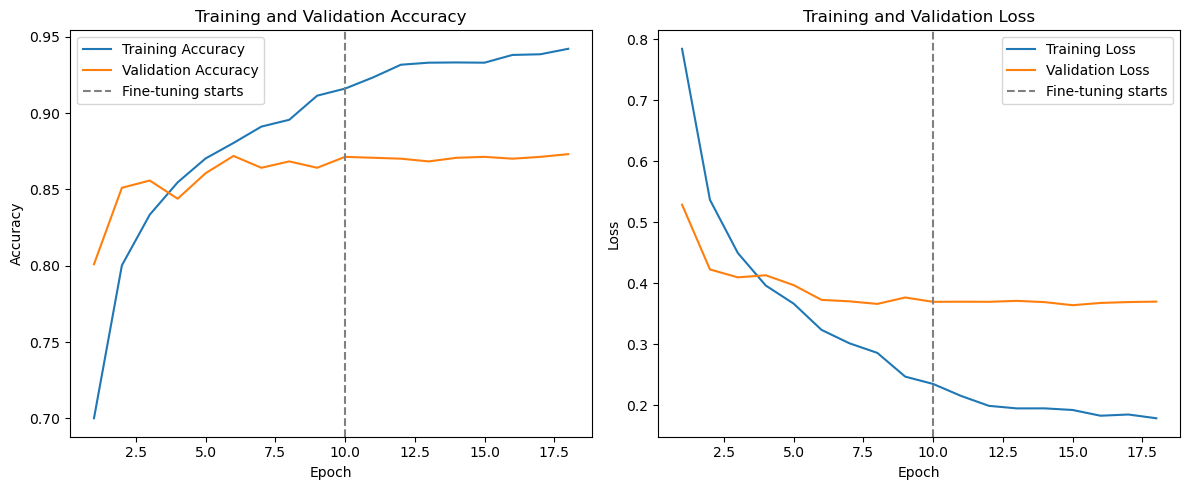

In [146]:
import matplotlib.pyplot as plt

# Combine training history
acc = history['accuracy'] + fine_tune_history.history['accuracy']
val_acc = history['val_accuracy'] + fine_tune_history.history['val_accuracy']

loss = history['loss'] + fine_tune_history.history['loss']
val_loss = history['val_loss'] + fine_tune_history.history['val_loss']

# Plot
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.axvline(x=len(history['accuracy']), color='gray', linestyle='--', label='Fine-tuning starts')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.axvline(x=len(history['loss']), color='gray', linestyle='--', label='Fine-tuning starts')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import pickle
from tensorflow.keras.models import load_model

dump_base_path = "dumps/"

# --- Saving ---

# # Save Keras model (architecture + weights + optimizer)
# model.save(dump_base_path + 'vgg_transfer_learning_model_1.h5')

# # Save Label Encoder
# with open(dump_base_path + 'label_encoder.pkl', 'wb') as f:
#     pickle.dump(label_encoder, f)

# # Save metadata
# with open(dump_base_path + 'metadata_seq.pkl', 'wb') as f:
#     pickle.dump(metadata_seq, f)


# # Save tokenizer
# with open(dump_base_path + 'tokenizer.pkl', 'wb') as f:
#     pickle.dump(tokenizer, f)

# # save training history
# with open(dump_base_path + 'training_history.pkl', 'wb') as f:
#     pickle.dump(history.history, f)


# --- Loading later ---

# Load model
model = load_model(dump_base_path +'vgg_transfer_learning_model_1.h5')

# Load Label Encoder
with open(dump_base_path + 'label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

# Load metadata scaler
with open(dump_base_path + 'metadata_seq.pkl', 'rb') as f:
    metadata_seq = pickle.load(f)

# Load metadata scaler
with open(dump_base_path + 'tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Load training history (optional)
with open(dump_base_path + 'training_history.pkl', 'rb') as f:
    history = pickle.load(f)


In [148]:
model.save(dump_base_path + "vgg_finetuned_model.h5")  # Saves architecture, weights, and optimizer state

In [99]:
import pickle

# Save history, label encoders, scalers, or other config
dump_data = {
    "initial_history": history,
    "finetune_history": fine_tune_history,
    "label_encoder": label_encoder,  
    "train_gen": train_gen,
    "val_gen": val_gen,
}

with open(dump_base_path + "vgg_model_extras.pkl", "wb") as f:
    pickle.dump(dump_data, f)


In [95]:
from tensorflow.keras.models import load_model

# Load model
model = load_model(dump_base_path + "vgg_finetuned_model.h5")

# Load extras
with open(dump_base_path + "vgg_model_extras.pkl", "rb") as f:
    extras = pickle.load(f)

history = extras["initial_history"]
fine_tune_history = extras["finetune_history"]
label_encoder = extras.get("label_encoder")
train_gen = extras.get("train_gen")
val_gen = extras.get("val_gen")

In [101]:
np.save(dump_base_path + "X_img_train.npy", X_img_train)
np.save(dump_base_path + "X_meta_train.npy", X_meta_train)
np.save(dump_base_path + "y_train.npy", y_train)
np.save(dump_base_path + "X_img_val.npy", X_img_val)
np.save(dump_base_path + "X_meta_val.npy", X_meta_val)
np.save(dump_base_path + "y_val.npy", y_val)


